In [1]:
import os
import sys
import cv2
from affine import Affine
from osgeo import gdal
from tqdm import tqdm
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Polygon
from shapely.affinity import affine_transform
from shapely.ops import nearest_points
from shapely import hausdorff_distance
from matplotlib import pyplot as plt

# IoU and Hausdorff

In [2]:
def calculate_stats(df1, df2):
    # Define a function to calculate the intersection over union (IoU) of two polygons
    def iou(p1, p2):
        intersection = p1.intersection(p2).area
        union = p1.union(p2).area
        return intersection / union
    
    # Initialize an empty list to store the matched pairs
    matched_pairs = []
    
    # Loop through the first polygon series
    for i, row1 in df1.iterrows():
        # Get the polygon geometry from the row
        p1 = row1.geometry
        
        # Loop through the second polygon series
        for j, row2 in df2.iterrows():
            # Get the polygon geometry from the row
            p2 = row2.geometry
            
            # Calculate the IoU of the two polygons
            iou_score = iou(p1, p2)
            
            # If the IoU is over 0.7, append the pair and the score to the matched list
            if iou_score > 0.7:
                matched_pairs.append((i, j, iou_score))
    
    # Print the number of matched pairs
    print(f"There are {len(matched_pairs)} matched pairs.")
    
    # Initialize two empty lists to store the mean IoU and Hausdorff distances
    iou = []
    hausdorff = []
    
    # Loop through the matched pairs
    for pair in matched_pairs:
        # Get the indices and the IoU score from the pair
        i, j, iou_score = pair
        
        # Get the polygon geometries from the dataframes using the indices
        p1 = df1.loc[i, "geometry"]
        p2 = df2.loc[j, "geometry"]
        
        # Calculate the Hausdorff distance of the two polygons
        hausdorff_distance = p1.hausdorff_distance(p2)
        
        # Append the IoU score and the Hausdorff distance to the lists
        iou.append(iou_score)
        hausdorff.append(hausdorff_distance)
    
    # Calculate the mean IoU and Hausdorff distances from the lists
    mean_iou = sum(iou) / len(iou)
    mean_hausdorff = sum(hausdorff) / len(hausdorff)
    
    # Print the results
    print(f"The mean IoU of the matched pairs is {mean_iou:.3f}.")
    print(f"The mean Hausdorff distance of the matched pairs is {mean_hausdorff:.3f}.")

    return iou, hausdorff


In [ ]:
# read the vector ploygons dataframe for results from elementary, sophisticated methods and ground truth 
df_elementary = gpd.read_file('~/Dufour_Origine_Aire-la-Ville_Plan_12/aggregated_init_projected.shp')
df_sophisticated = gpd.read_file('~/Dufour_Origine_Aire-la-Ville_Plan_12/aggregated_final_projected.shp')
df_gt = gpd.read_file('~/Dufour_Origine_Aire-la-Ville_Plan_12/ArcGIS/Aire-la-Ville-plan-12/Aire-la-Ville-plan-12.gdb', layer='polygons').explode()

In [4]:
sophisticated_iou, sophisticated_hausdorff = calculate_stats(df_gt, df_sophisticated)

There are 202 matched pairs.
The mean IoU of the matched pairs is 0.971.
The mean Hausdorff distance of the matched pairs is 0.729.


In [5]:
elementary_iou, elementary_hausdorff = calculate_stats(df_gt, df_elementary)

There are 199 matched pairs.
The mean IoU of the matched pairs is 0.979.
The mean Hausdorff distance of the matched pairs is 0.853.


In [6]:
np.quantile(elementary_hausdorff, 0.5), np.quantile(sophisticated_hausdorff, 0.5)

(0.1166378046258584, 0.132796275011888)

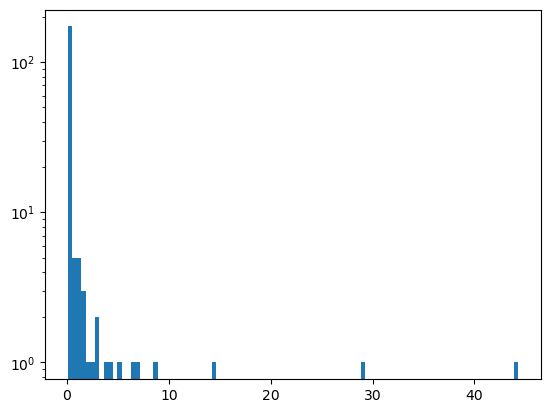

In [7]:
plt.hist(elementary_hausdorff, bins=100, log=True)
plt.show()